<a href="https://colab.research.google.com/github/vnandigam/CHM_lidar_lidR/blob/main/CHM_lidar_pc_lidR_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Canopy Height Model (CHM) and forest canopy metrics from lidar point clouds using lidR**

This R notebook processes airborne lidar data (in LAZ/LAS format) using the lidR package (https://r-lidar.github.io/lidRbook/) to generate essential forestry and ecology products. The workflow produces Canopy Height Models (CHM), smoothed CHMs, gridded canopy metrics, individual tree detections with convex hulls, and crown-level measurements. All processing steps are sequentially organized to ensure reproducible analysis of point cloud data.

This work was supported by the National Science Foundation under awards 2409885, 2409886 & 2409887. - www.openforest4d.org

**Step 0: Install and Load Packages**

Install and load required libraries. **This step may take up to 25 minutes to complete.**

In [25]:
# Set CRAN mirror once globally
options(repos = "https://cran.rstudio.com/")

# Install pacman only if not available
if (!requireNamespace("pacman", quietly = TRUE)) {
  install.packages("pacman")
}

# Load packages using pacman for easier management in Colab
pacman::p_load(
  lidR,        # Lidar data processing
  terra,       # Raster handling
  raster,      # Legacy support (used in Compute Canopy Metrics Grid)
  sp,          # Spatial data structures
  sf,          # Simple features
  RCSF         # Cloth Simulation Filter
  #viridis     # Optional for Color palettes in plots
  #future      # Optional for parallel processing
)

# Parallel processing configuration optimized for Colab's environment
# Colab typically has 2 CPUs for free tier; adjust accordingly if Pro or Pro+ is used
#library(future)
#available_cores <- parallel::detectCores(logical = FALSE)  # Physical cores count
#cores_to_use <- max(1, available_cores - 1)               # Leave one core free

#plan(multisession, workers = cores_to_use)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


raster installed



**Step 1: Define Custom Metrics Function**

Define the f_metrics function for canopy metrics computation (used later).

In [2]:
f_metrics <- function(Z, n) {
  # Strata: Proportion of Z values in the range of 2 to 5 meters
  strata = if (length(Z) > 0) sum(Z > 2 & Z < 5, na.rm = TRUE) / sum(!is.na(Z)) else 0
  # Canopy Cover: Proportion of returns in the first return
  #Zcov = length(Z[Z >= 2 & n == 1]) / length(Z[n == 1])
  Zcov <- sum(Z >= 2 & n == 1) / sum(n == 1)
  # Compute percentiles of Z values.
  # From 5% to 95% increased by 5%; from 96% to 100% increased by 1%.
  percentiles = quantile(Z, c(seq(0.05, 0.95, 0.05), seq(0.96, 1, 0.01)))

  # Create a list of computed metrics
  list_metrics = list(
    COV = Zcov,            # Canopy cover
    Hmean = mean(Z),       # Mean canopy height
    HSD = sd(Z),           # Standard deviation of height
    HMAX = max(Z),         # Maximum height
    S = strata             # Strata value
  )

  # Add percentile metrics to the list
  for (i in seq_along(percentiles)) {
    list_metrics[[paste0("H", gsub("\\.", "", names(percentiles)[i]), "TH")]] <-
      percentiles[i]
  }

  return(list_metrics)  # Return the list of metrics
}

**Step 2: Specify Input lidar point cloud file and resolution**

Specify the input laz file and parameters (e.g., resolution). Here we use an example laz file from OpenTopography (www.opentopography.org, dataset DOI - https://doi.org/10.5069/G96M351N)

In [3]:
# Define the URL for the LAZ file
lidar_url <- "https://opentopography.s3.sdsc.edu/pc-bulk/CA18_Thompson/273500_4172000.laz"

# Create a temporary file with .laz extension to download the file
temp_laz <- tempfile(pattern = "lidar_", fileext = ".laz")

# Download the LAZ file to the temporary location
download.file(lidar_url, temp_laz, mode = "wb")

# Create output directory if it doesn't exist
output_dir <- "/content/lidar_output"
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Set raster resolution (e.g., 1 meter)
res <- 1

**Step 3: Read lidar point cloud data file**

Use the readLAS function from the lidR R package to read the lidar point cloud file - select only the  X, Y, Z, intensity, number of returns and classification and excludes points with a Z (elevation) value below 0.

In [4]:
# Load the LAZ file using lidR readLAS function
las <- readLAS(temp_laz, select = "xyzrnc", filter = "-drop_z_below 0")
if (is.empty(las)) {
  stop("Error: LAZ file could not be read or is empty.")
}

# Example: Print summary of the LAS file to confirm successful load
print(summary(las))

class        : LAS (v1.4 format 3)
memory       : 229.9 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253584 m²
points       : 6.7 million points
type         : airborne
density      : 26.41 points/m²
density      : 25.18 pulses/m²
File signature:           LASFm� 
File source ID:           57453 
Global encoding:
 - GPS Time Type: GPS Week Time 
 - Synthetic Return Numbers: no 
 - Well Know Text: CRS is WKT 
 - Aggregate Model: false 
Project ID - GUID:        00000000-0000-0000-0000-000000000000 
Version:                  1.4
System identifier:        PDAL 
Generating software:      PDAL 2.2.0 (ff32c2) 
File creation d/y:        91/2019
header size:              375 
Offset to point data:     1777 
Num. var. length record:  2 
Point data format:        3 
Point data record length: 34 
Num. of point records:    6696583 
Num. of points by return: 6384399 267084 41236 3864 0 0 0 0 0 0 0 0 0 0 0

**Step 4: Remove Duplicates**

Identify and remove duplicated points within the lidar point cloud file.

In [5]:
las <- filter_duplicates(las)
print(las)  # Check after removal

class        : LAS (v1.4 format 3)
memory       : 229.8 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253584 m²
points       : 6.69 million points
type         : airborne
density      : 26.4 points/m²
density      : 25.17 pulses/m²


**Step 5: Classify and Remove Noise**

Classify and filter out noise using Statistical Outlier Removal (SOR). The SOR algorithm checks each point's mean distance to its 10 nearest neighbors (k=10) and marks points as noise if their distance is greater than the average plus 3 times the standard deviation (m=3). The quantile = FALSE means it uses standard deviation thresholding rather than quantile-based.

In [6]:
las <- classify_noise(las, algorithm = sor(k = 10, m = 3, quantile = FALSE))
las <- filter_poi(las, Classification != 18)  # Remove noise (Class 18)
print(las)  # Inspect

class        : LAS (v1.4 format 3)
memory       : 225.1 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253520 m²
points       : 6.56 million points
type         : airborne
density      : 25.86 points/m²
density      : 24.81 pulses/m²


**Step 6: Generate Digital Surface Model (DSM)**

Create and plot the DSM (top surface, including vegetation).

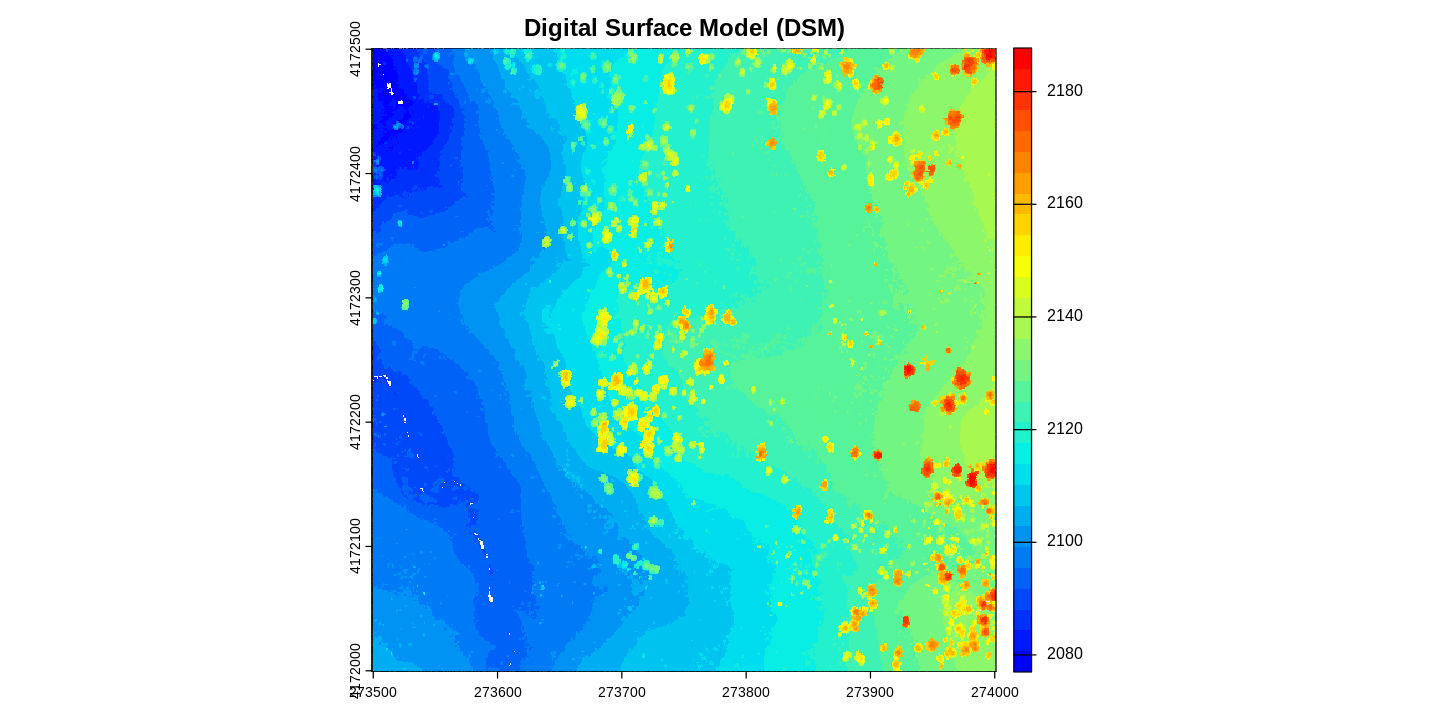

In [54]:
dsm <- rasterize_canopy(las, res = res, algorithm = p2r())
col <- height.colors(30)  # Color palette
#col <- colorRampPalette(c("#7B4F12", "#B27243", "#D6A45F", "#E6C96A", "#C8D974", "#82A84B", "#99C092"))(30) #optional custom color
plot(dsm, col = col, main = "Digital Surface Model (DSM)")

**Step 7: Classify Ground Points**

Classify ground using Cloth Simulation Filter (CSF).

In [39]:
las <- classify_ground(las, csf(cloth_resolution = 2, rigidness = 3L))
print(las)  # Check classifications

Original dataset already contains 5244423 ground points. These points were reclassified as 'unclassified' before performing a new ground classification.



class        : LAS (v1.4 format 3)
memory       : 225.1 Mb 
extent       : 273499.8, 274000.4, 4172000, 4172500 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / UTM zone 11N 
area         : 253520 m²
points       : 6.56 million points
type         : airborne
density      : 25.86 points/m²
density      : 24.81 pulses/m²


**Step 8: Generate Digital Terrain Model (DTM)**

Generate DTM (bare earth surface) using Triangulated Irregular Network (TIN) algorithm which constructs a mesh of triangles between ground points and interpolates elevations to generate a continuous surface.

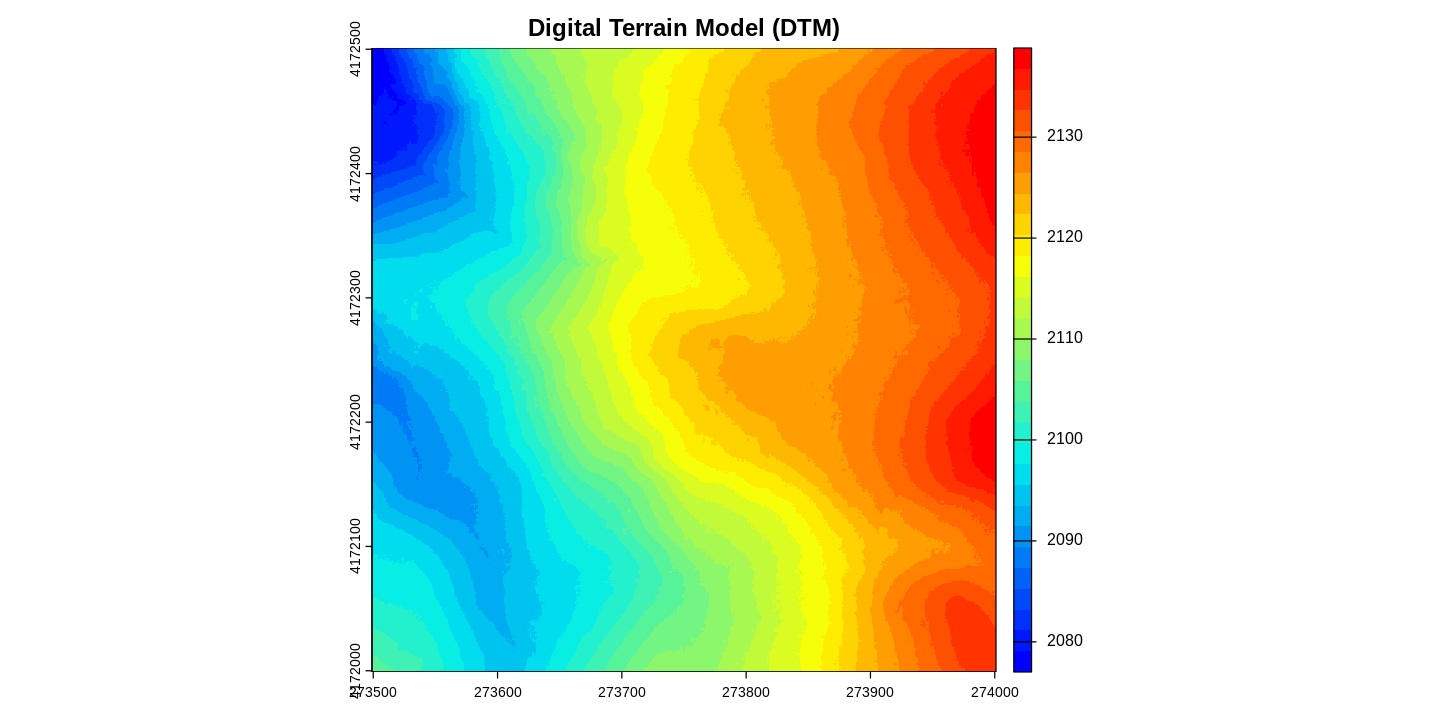

In [55]:
dtm <- rasterize_terrain(las, res = res, algorithm = tin())
plot(dtm, col = col, main = "Digital Terrain Model (DTM)")
#plot_dtm3d(dtm)  # Optional 3D plot (requires snapshot in Colab)

**Step 9: Normalize Point Cloud**

Perform height normalization of the lidar point cloud data relative to the DTM (height above ground).

In [45]:
las_norm <- normalize_height(las, algorithm = dtm)

**Step 10: Generate Canopy Height Model (CHM)**

Create and plot the CHM (vegetation heights).

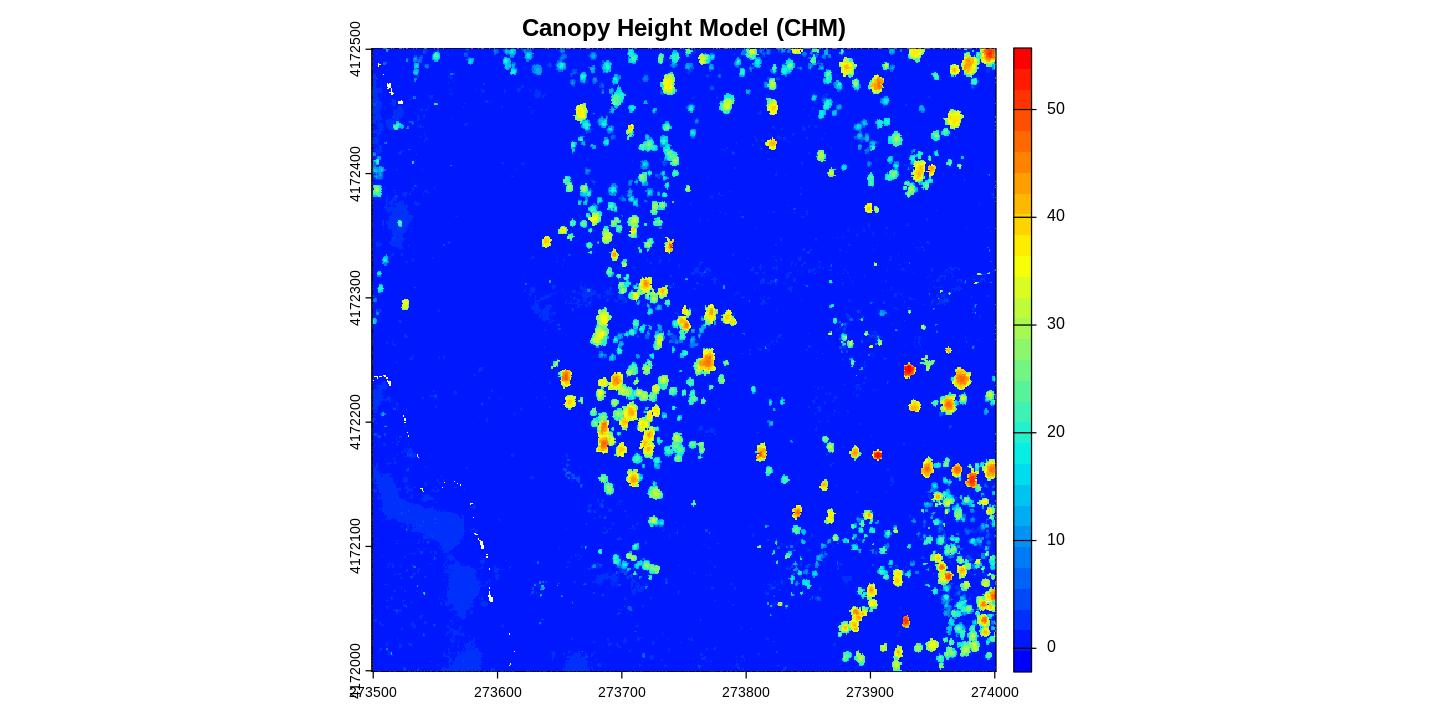

In [56]:
chm <- rasterize_canopy(las_norm, res = res, algorithm = p2r())
plot(chm, col = col, main = "Canopy Height Model (CHM)")

# Save CHM and normalized LAS (optional)
#writeRaster(chm, file.path(output_dir, "CHM.tif"), overwrite = TRUE)
#writeLAS(las_norm, file.path(output_dir, "laz_norm.laz"))

**Step 11: Compute Canopy Metrics Grid**

Apply custom metrics to generate a gridded raster of canopy statistics.

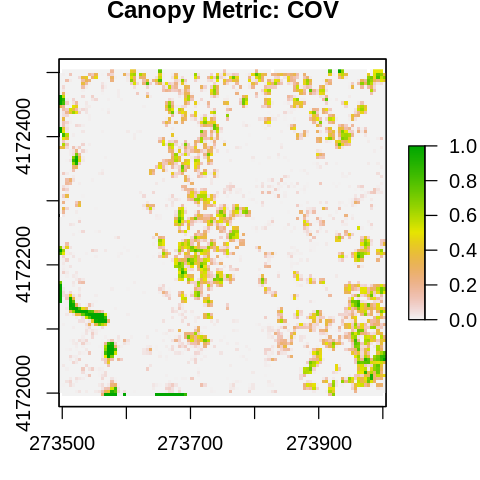

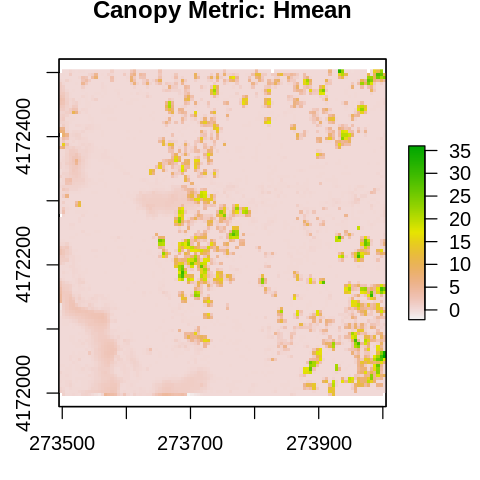

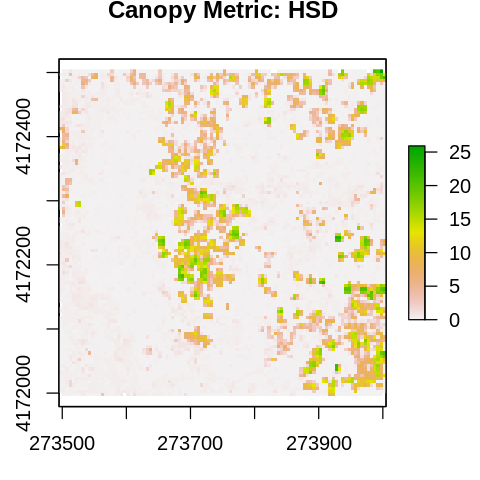

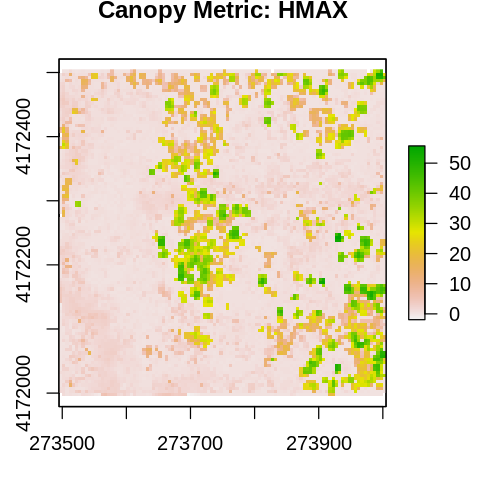

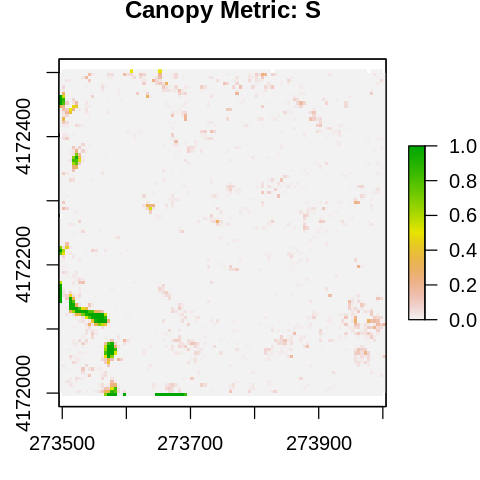

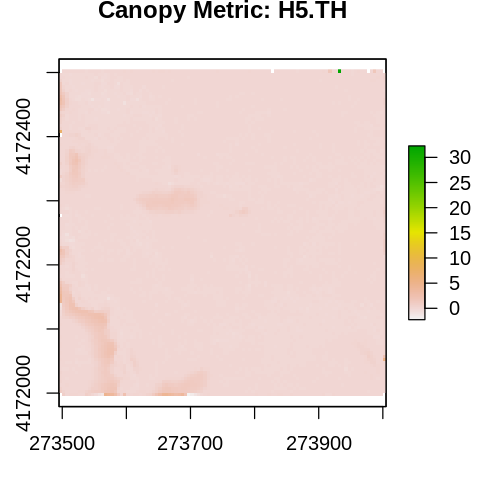

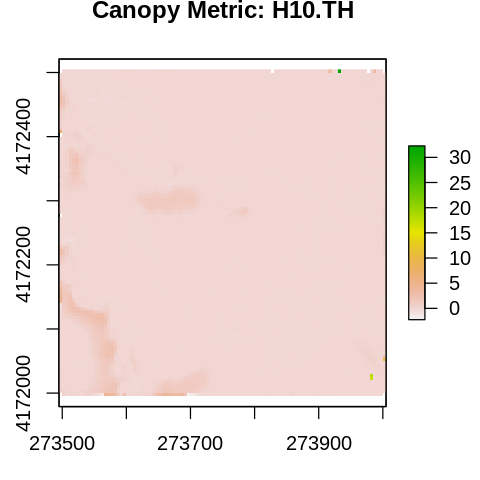

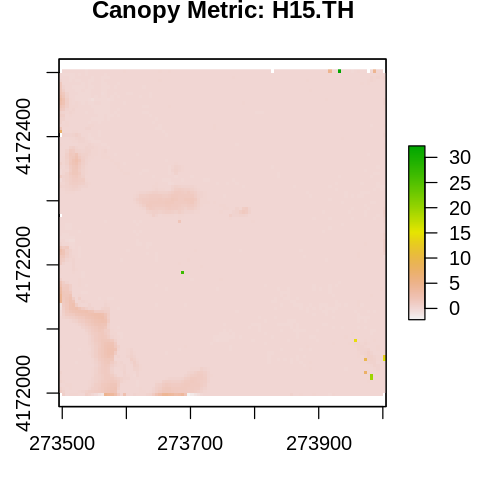

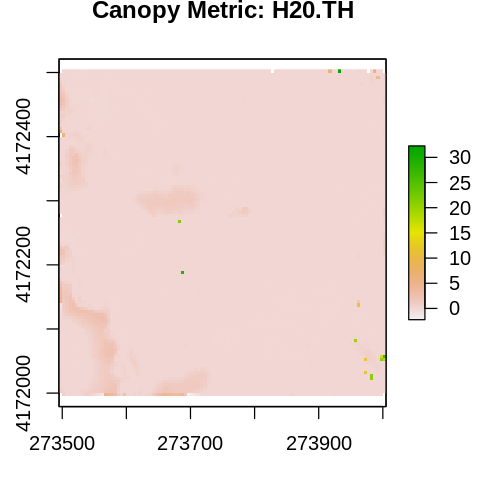

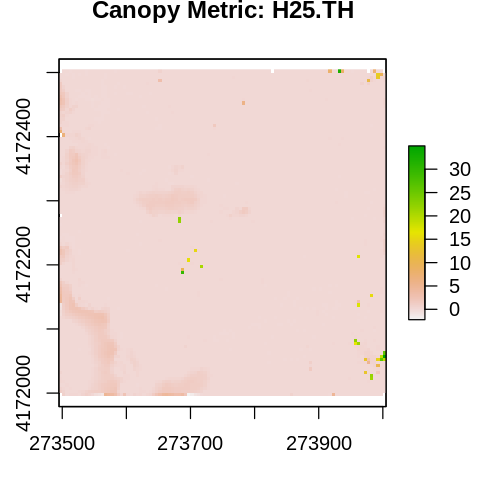

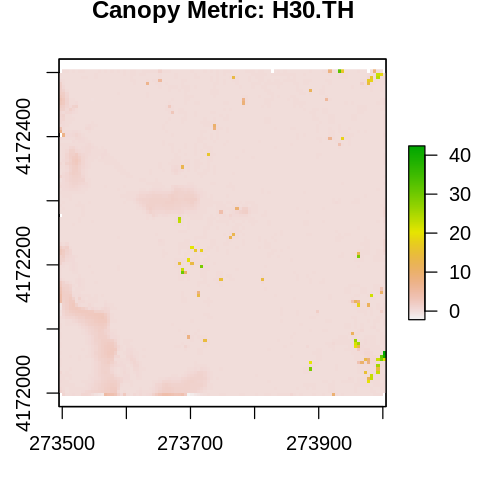

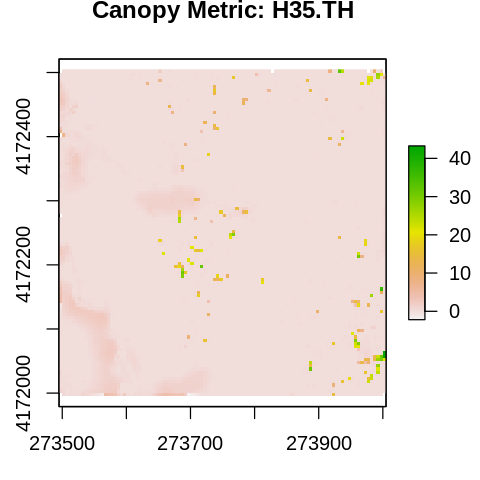

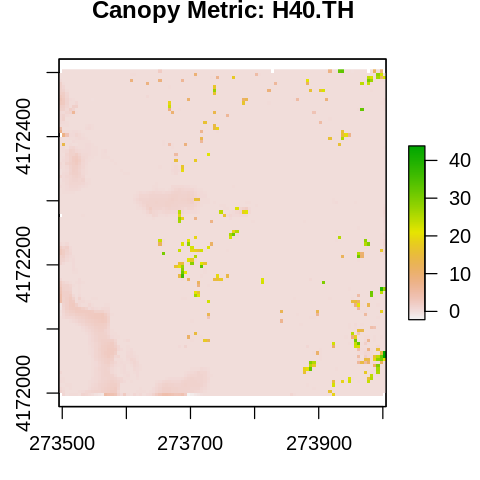

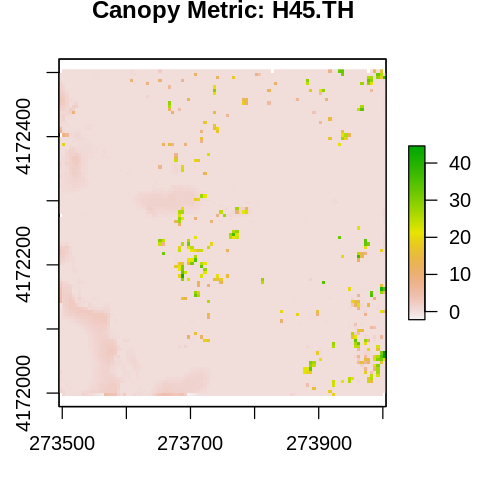

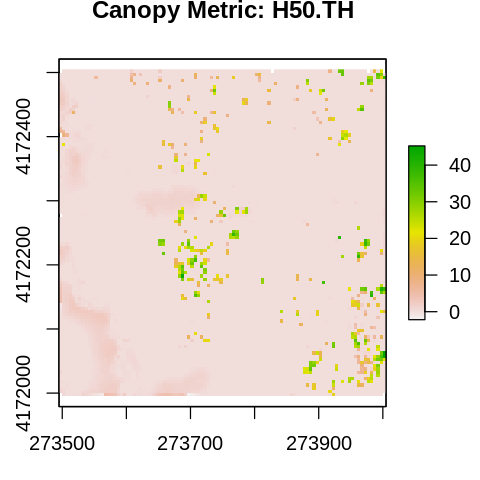

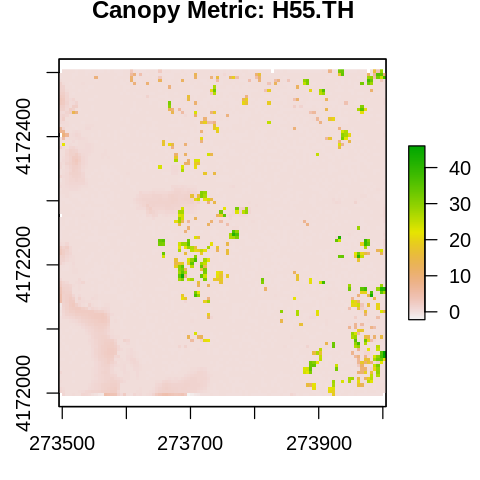

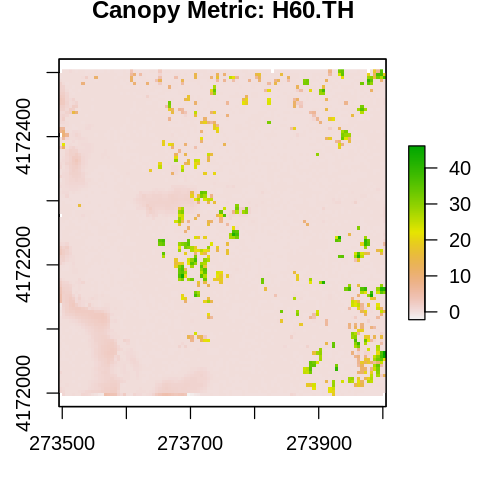

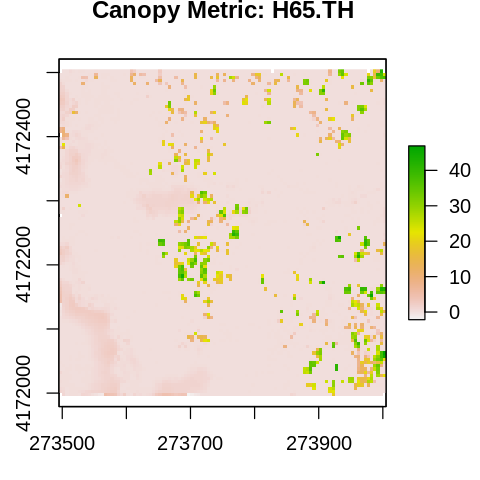

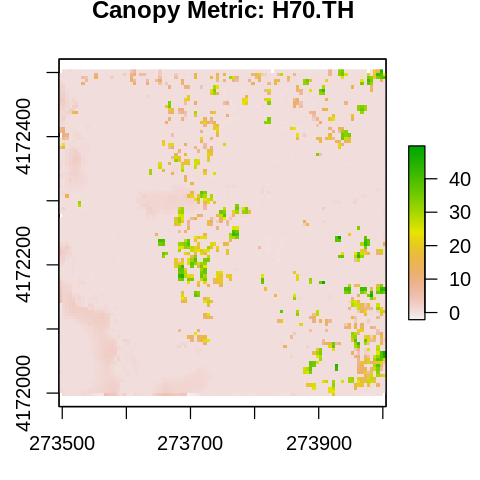

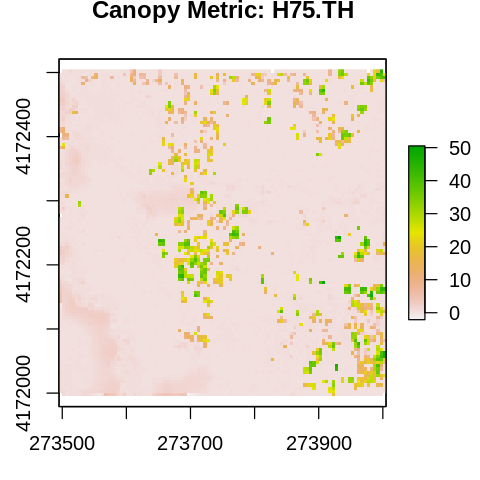

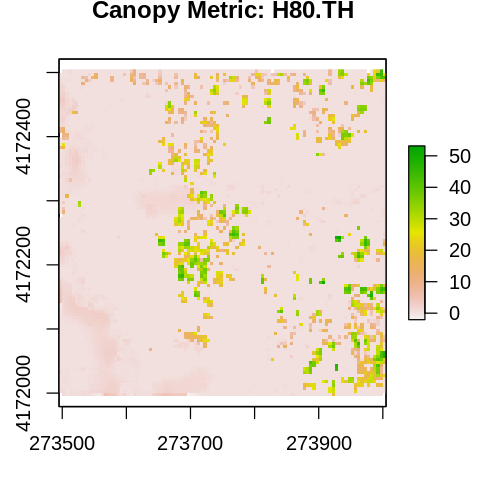

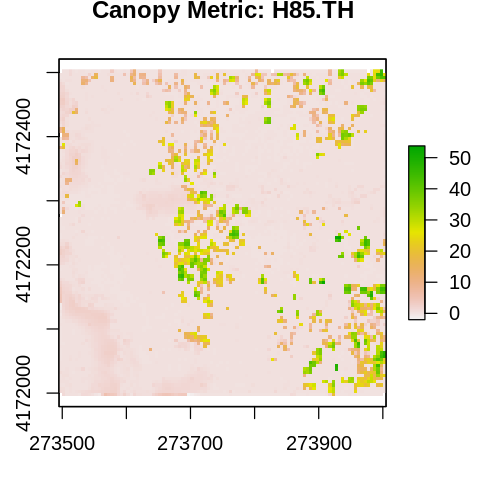

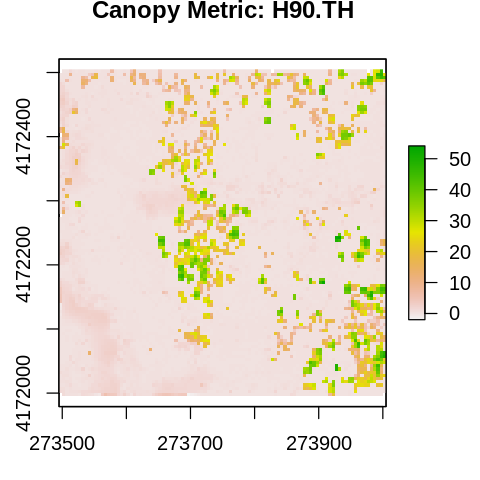

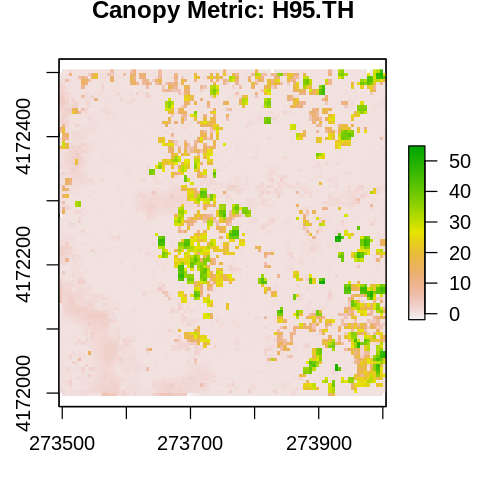

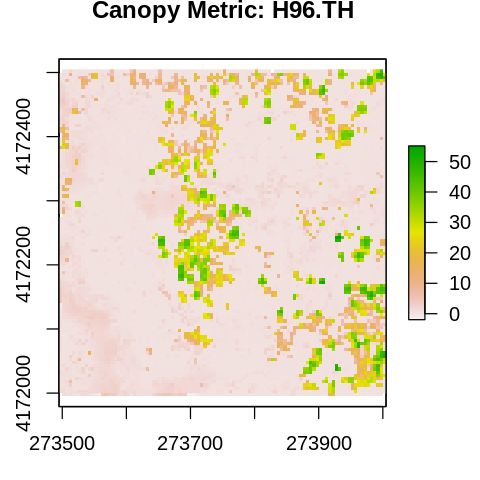

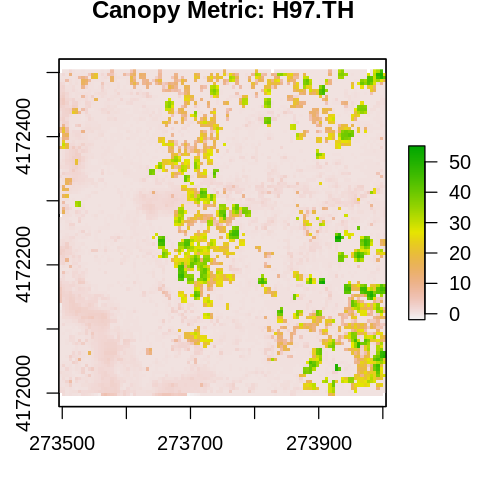

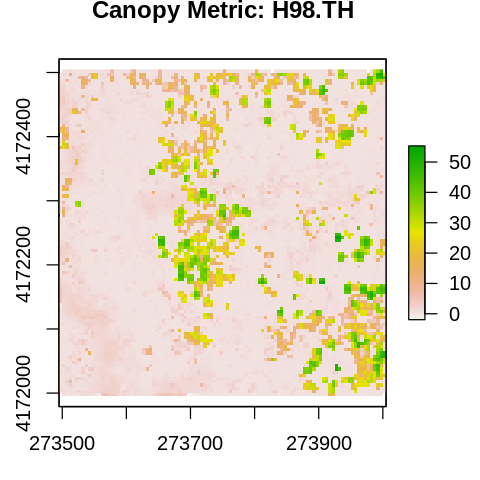

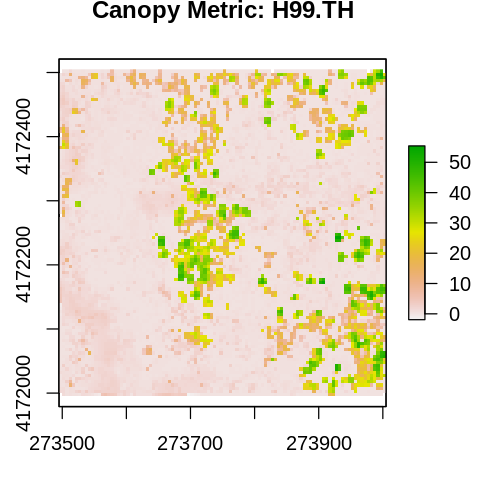

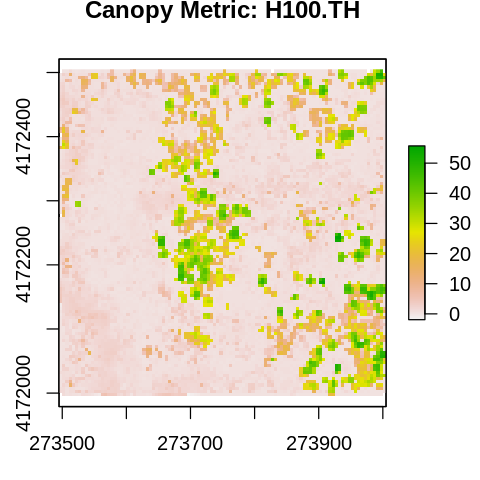

In [57]:
canopy_metrics_grid <- grid_metrics(las_norm,
                                    func = ~f_metrics(Z, ReturnNumber),
                                    res = 5)

# Make each metric plot large
options(repr.plot.width = 4, repr.plot.height = 4)

# Loop through layers
for (name in names(canopy_metrics_grid)) {
  terra::plot(
    canopy_metrics_grid[[name]],
    main = paste("Canopy Metric:", name),
    legend.width = 1.5
  )
}


**Step 12: Smooth CHM**

Apply median smoothing to the CHM for better tree detection.

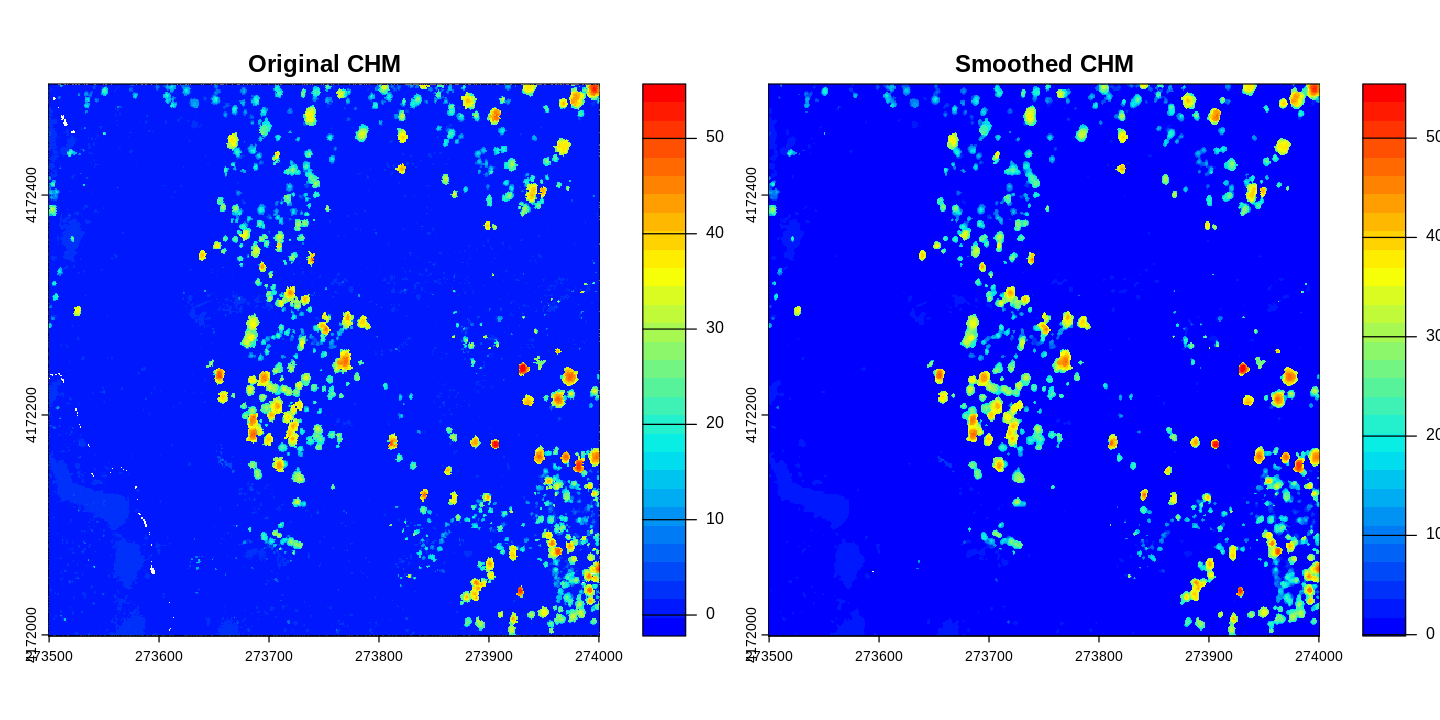

In [59]:
kernel <- matrix(1, 3, 3)  # 3x3 kernel
chm_smoothed <- terra::focal(chm, w = kernel, fun = median, na.rm = TRUE)

# Increase plot size (in inches)
options(repr.plot.width = 12, repr.plot.height = 6)

# Visualize original vs. smoothed
par(mfrow = c(1, 2))
plot(chm, col = col, main = "Original CHM")
plot(chm_smoothed, col = col, main = "Smoothed CHM")

# Save smoothed CHM (optional)
# writeRaster(chm_smoothed, file.path(output_dir, "CHM_smoothed.tif"), overwrite = TRUE)

**Step 13: Detect Tree Tops**

Locate tree tops using local maxima filter on smoothed CHM.

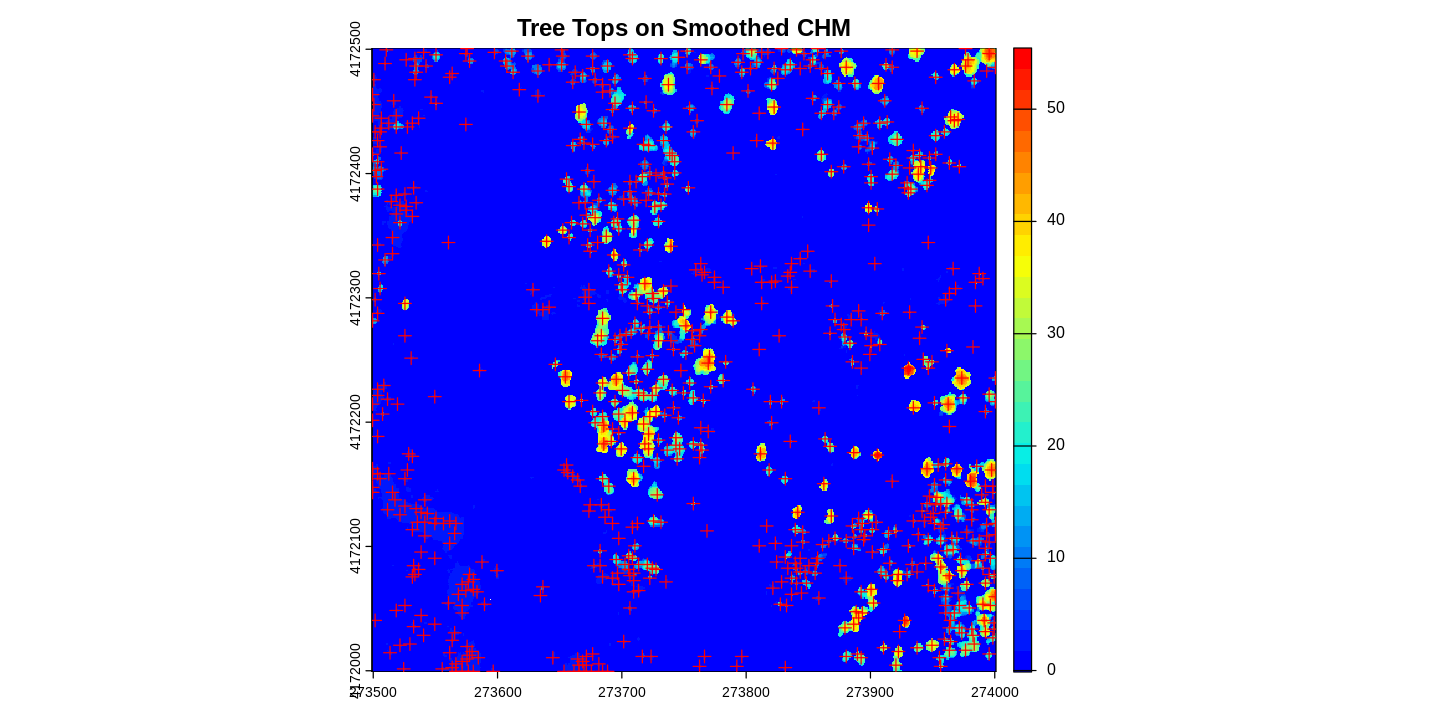

In [60]:
ttops <- locate_trees(chm_smoothed, lmf(5))  # 5m radius
plot(chm_smoothed, col = col, main = "Tree Tops on Smoothed CHM")
plot(sf::st_geometry(ttops), add = TRUE, pch = 3, col = "red")

**Step 14: Segment Individual Trees**

Segment trees using Silva2016 algorithm (https://rdrr.io/cran/lidR/man/its_silva2016.html).

In [61]:
las_itc <- segment_trees(las_norm, silva2016(chm_smoothed, ttops))
plot(las_itc, color = "treeID", main = "Segmented Trees")

**Step 15: Delineate Tree Crowns**

Compute convex hulls for tree crowns and plot.

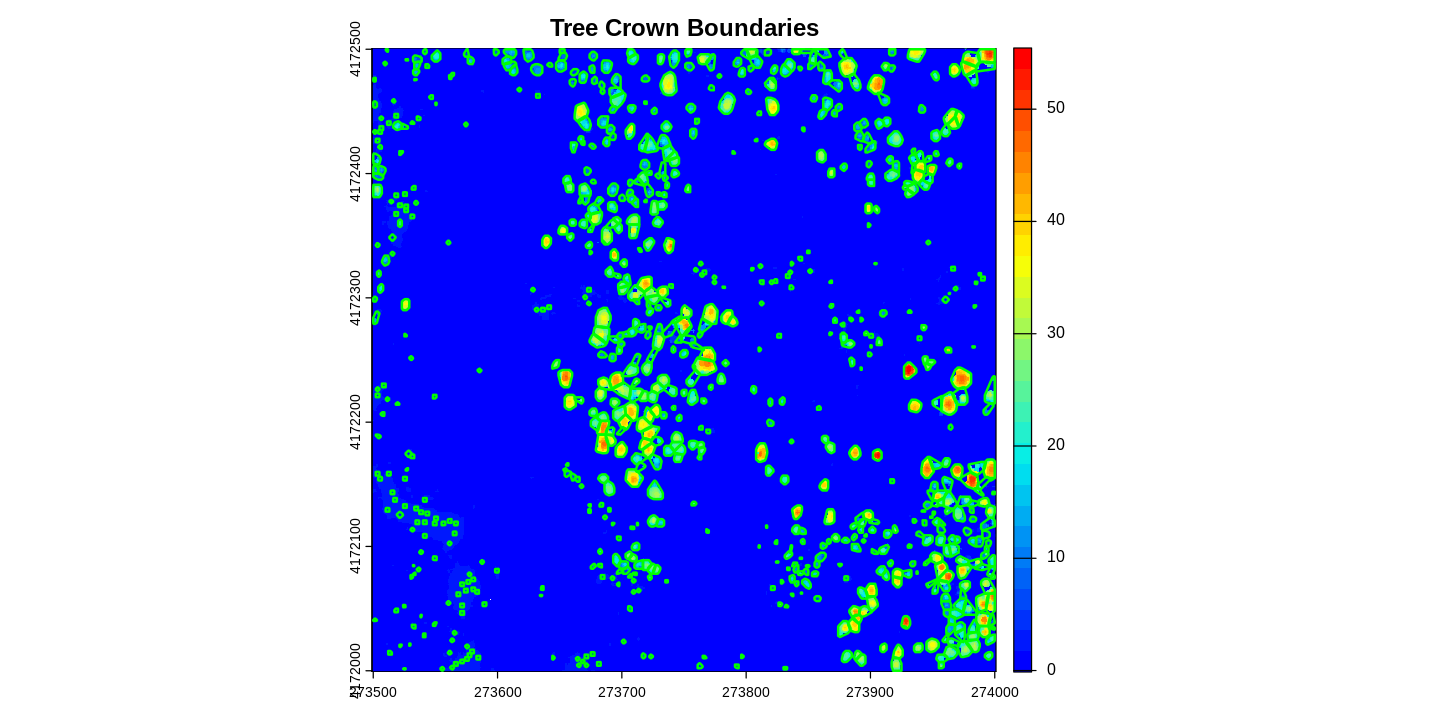

In [62]:
convex_hulls <- delineate_crowns(las_itc)
plot(chm_smoothed, col = col, main = "Tree Crown Boundaries")
plot(convex_hulls, add = TRUE, lwd = 2, border = "green")

**Step 16: Compute Crown-Level Metrics (Optional)**

Define and apply a function to compute metrics per crown (e.g., max height, mean height).

Simple feature collection with 795 features and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 273500 ymin: 4172000 xmax: 274000 ymax: 4172500
Projected CRS: NAD83(2011) / UTM zone 11N
First 10 features:
   treeID  maxz     meanz       sdz       varz     p98
1       5 13.65  6.520206  5.601925  31.381565 13.2904
2       6  9.46  2.493024  2.835884   8.042238  8.7948
3       7 34.16 13.020497 11.575033 133.981397 32.7786
4       8 37.46 14.354069 15.474443 239.458392 36.7500
5       9 13.49  3.878207  4.475311  20.028410 12.6530
6      10 17.31  5.632691  5.330437  28.413554 14.3446
7      11 24.92  8.008389  9.194815  84.544631 23.3772
8      12 30.46  6.277875  8.066295  65.065123 29.6108
9      13 38.09 14.510768 15.585703 242.914130 37.1352
10     14  4.55  1.230615  1.548801   2.398783  4.1872
                         geometry
1  POLYGON ((273511.9 4172498,...
2  POLYGON ((273654 4172497, 2...
3  POLYGON ((273808 4172495, 2...
4  POLYGON ((273843.7 4172498,.

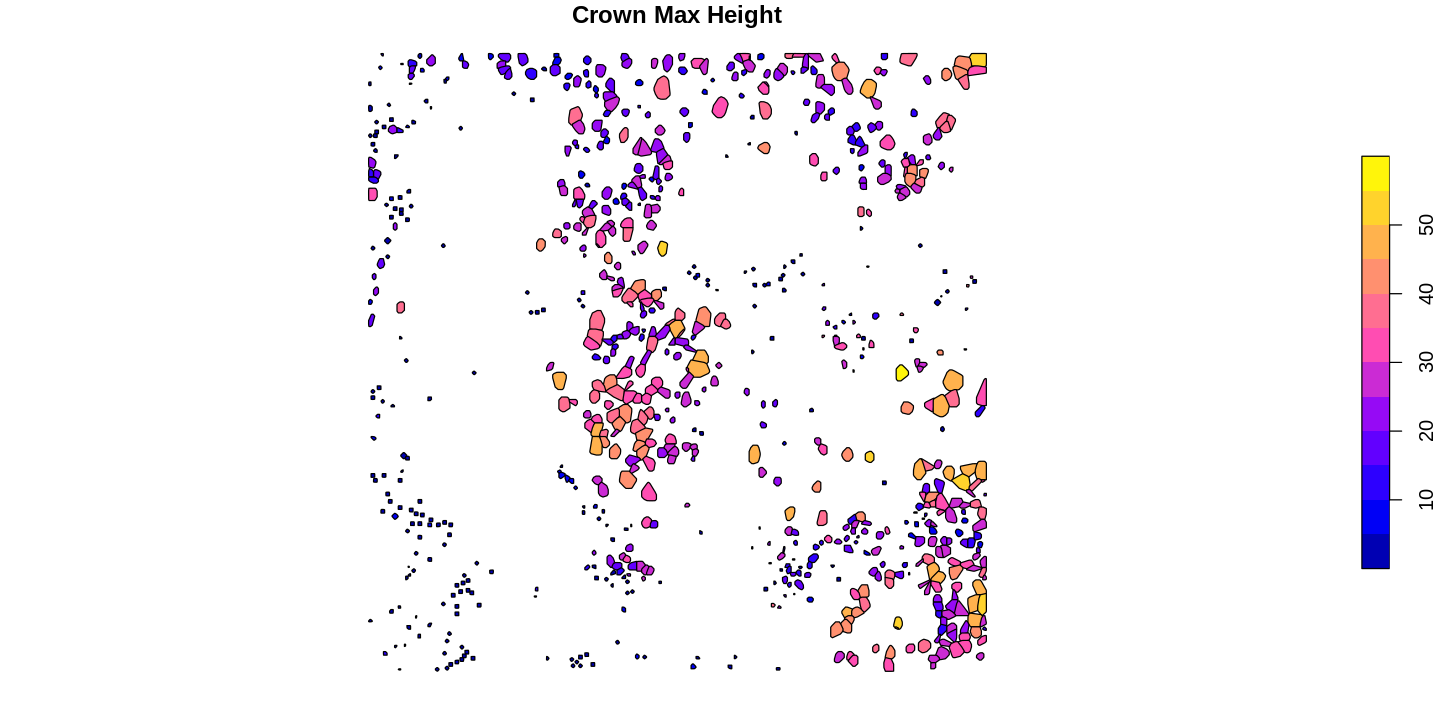

In [63]:
# Define crown metrics function
fun <- ~list(maxz = max(Z),               # Maximum height
             meanz = mean(Z),             # Mean height
             sdz = sd(Z),                 # Standard deviation of height
             varz = var(Z),               # Variance of height
             p98 = quantile(Z, 0.98))     # 98th percentile

# Compute crown metrics
crown_metrics <- crown_metrics(las_itc, func = fun, geom = "convex")
print(crown_metrics)  # Inspect as table
plot(crown_metrics["maxz"], main = "Crown Max Height")  # Example plot